#Object Detection With Yolo

##Describe about datasets

Dataset <a href="https://www.kaggle.com/datasets/muhammetzahitaydn/hardhat-vest-dataset-v3">LINK</a>

Classes:
    Helmet
    Vest
    Head


<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <style>
        table {
            width: 50%;
            border-collapse: collapse;
            margin: 20px auto;
            font-family: Arial, sans-serif;
        }
        th, td {
            border: 1px solid #ddd;
            text-align: center;
            padding: 8px;
        }
        th {
            background-color: #f4f4f4;
            font-weight: bold;
        }
        tr:nth-child(even) {
            background-color: #f9f9f9;
        }
        tr:hover {
            background-color: #f1f1f1;
        }
    </style>
</head>
<body>
    <h2 style="text-align: center;">Instance Statistics</h2>
    <table>
        <thead>
            <tr>
                <th>Instances</th>
                <th>Train</th>
                <th>Test</th>
                <th>Val</th>
                <th>Total</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td>Helmet</td>
                <td>44240</td>
                <td>6895</td>
                <td>6725</td>
                <td>57860</td>
            </tr>
            <tr>
                <td>Vest</td>
                <td>7794</td>
                <td>1156</td>
                <td>1074</td>
                <td>10024</td>
            </tr>
            <tr>
                <td>Head</td>
                <td>98652</td>
                <td>12565</td>
                <td>13609</td>
                <td>124826</td>
            </tr>
        </tbody>
    </table>
</body>
</html>

##Prepare Dataset

We need to upload file kaggle.json from generate token

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zhangwusan","key":"17c0caaccc243172b3b0ec8e74fbc233"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%%writefile dataset.sh

#!/bin/bash

DATASET_NAME="muhammetzahitaydn/hardhat-vest-dataset-v3"

# Function to print error messages in red
print_error() {
    echo -e "\033[31mError: $1\033[0m"  # Red text
}

# Function to print success messages in green
print_success() {
    echo -e "\033[32m$1\033[0m"  # Green text
}

# Validate Kaggle CLI and API token
validate_kaggle() {
    if ! command -v kaggle &> /dev/null; then
        print_error "[ERROR] Kaggle CLI is not installed. Please install it using 'pip install kaggle'."
        exit 1
    fi

    # Check if kaggle.json exists and is in the correct location
    if [ ! -f ~/.kaggle/kaggle.json ]; then
        print_error "[ERROR] Kaggle API token (kaggle.json) not found in ~/.kaggle/. Please set it up."
        exit 1
    fi

    print_success "[SUCCESS] Kaggle CLI and token are valid."
}

validate_kaggle

# Download dataset from Kaggle
echo "Downloading dataset: $DATASET_NAME..."
kaggle datasets download -d "$DATASET_NAME"

# Check if the download was successful
if [ $? -eq 0 ]; then
    print_success "Dataset downloaded successfully."
else
    print_error "Dataset download failed. Please check the dataset name or your Kaggle setup."
    exit 1
fi

# Unzip the dataset if it is a ZIP file
if ls *.zip &> /dev/null; then
    echo "Unzipping dataset..."
    unzip -q *.zip -d /content/datasets
    print_success "Dataset unzipped successfully."
else
    echo "No ZIP file found to unzip."
fi

# Remove the dataset
echo "Removing downloaded dataset..."
rm *.zip

echo "Dataset preparation complete."

Writing dataset.sh


In [ ]:
!chmod +x dataset.sh
!./dataset.sh

[SUCCESS] Kaggle CLI and token are valid.
Dataset URL: https://www.kaggle.com/datasets/muhammetzahitaydn/hardhat-vest-dataset-v3
License(s): CC0-1.0
100% 4.19G/4.21G [00:57<00:00, 73.3MB/s]
100% 4.21G/4.21G [00:57<00:00, 78.4MB/s]
Dataset downloaded successfully.
Unzipping dataset...
Dataset unzipped successfully.
Removing downloaded dataset...
Dataset preparation complete.


In [ ]:
%%writefile config.yaml

train: /content/datasets/images/train
val: /content/datasets/images/val
test: /content/datasets/images/test

nc: 3

names:
  0: helmet
  1: vest
  2: head


Writing config.yaml


In [ ]:
import os

train_images_path = "datasets/images/train"
val_images_path = "datasets/images/val"
test_images_path = "datasets/images/test"
output_dir = "data"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Function to create text file with image paths
def create_image_list(image_folder, output_file):
    with open(output_file, 'w') as file:
        for image_name in os.listdir(image_folder):
            if image_name.endswith(('.jpg', '.png')):  # Adjust based on your image formats
                file.write(f"{os.path.join(image_folder, image_name)}\n")

# Generate train.txt and val.txt
create_image_list(train_images_path, os.path.join(output_dir, "train.txt"))
create_image_list(val_images_path, os.path.join(output_dir, "val.txt"))
create_image_list(test_images_path, os.path.join(output_dir, "test.txt"))

##Virtualize

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class HardHatVestDataset(Dataset):
    def __init__(self, folder="train", transform=None):
        """
        Initialize the dataset.
        Args:
            folder (str): Subfolder for the dataset, e.g., 'train', 'test', or 'val'.
            transform (callable, optional): Transformation to be applied to the images.
        """
        self.folder = folder
        self.transform = transform
        self.image_dir = os.path.join("datasets", "images", folder)
        self.label_dir = os.path.join("datasets", "labels", folder)
        self.image_paths = sorted(os.listdir(self.image_dir))
        self.label_paths = sorted(os.listdir(self.label_dir))
        self.class_names = ["helmet", "vest", "head"]

    def __len__(self):
        """Return the total number of samples."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Get an item by index.
        Args:
            idx (int): Index of the sample.
        Returns:
            tuple: (image, label), where image is a PIL Image and label is loaded as text or other format.
        """
        # Load the image
        image_path = os.path.join(self.image_dir, self.image_paths[idx])
        image = Image.open(image_path).convert("RGB")

        # Load the label
        label_path = os.path.join(self.label_dir, self.label_paths[idx])
        with open(label_path, 'r') as label_file:
            label = label_file.read().strip()

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        return image, label

    def show(self, index):
        """
        Display an image with its bounding boxes and labels.
        Args:
            index (int): Index of the image in the dataset.
        """
        image, label_data = self[index]

        # Convert image to a NumPy array if it's a Tensor
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()

        # Get actual image dimensions
        img_height, img_width = image.shape[:2]

        # Create a plot
        fig, ax = plt.subplots(1, figsize=(8, 8))
        ax.imshow(image)

        # Parse and draw each bounding box
        for line in label_data.strip().split("\n"):
            label_parts = line.split()
            class_id = int(label_parts[0])
            x_center, y_center, width, height = map(float, label_parts[1:])

            # Denormalize bounding box coordinates
            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height

            # Calculate top-left corner of the bounding box
            x_min = x_center - width / 2
            y_min = y_center - height / 2

            # Draw bounding box
            rect = patches.Rectangle(
                (x_min, y_min), width, height,
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax.add_patch(rect)

            # Add class label
            ax.text(
                x_min, y_min - 5,
                self.class_names[class_id],
                color='red', fontsize=12, backgroundcolor='white'
            )

        plt.axis("off")
        plt.show()

In [ ]:
# Example usage
if __name__ == "__main__":
    from torchvision import transforms

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    # Load the train dataset
    train_dataset = HardHatVestDataset(folder="train", transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

    # Load the test dataset
    test_dataset = HardHatVestDataset(folder="test", transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    # Load the val dataset
    val_dataset = HardHatVestDataset(folder="val", transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    # Iterate through the DataLoader
    for train, val, test in zip(train_loader, val_loader, test_loader):
        print("Train batch shape:", train[0].shape)
        print("Val batch shape:", val[0].shape)
        print("Test batch shape:", test[0].shape)
        break

    # Lenght of datasets
    print("Train dataset length:", len(train_dataset))
    print("Test dataset length:", len(test_dataset))
    print("Val dataset length:", len(val_dataset))

Train batch shape: torch.Size([8, 3, 224, 224])
Val batch shape: torch.Size([8, 3, 224, 224])
Test batch shape: torch.Size([8, 3, 224, 224])
Train dataset length: 17248
Test dataset length: 2455
Val dataset length: 2438


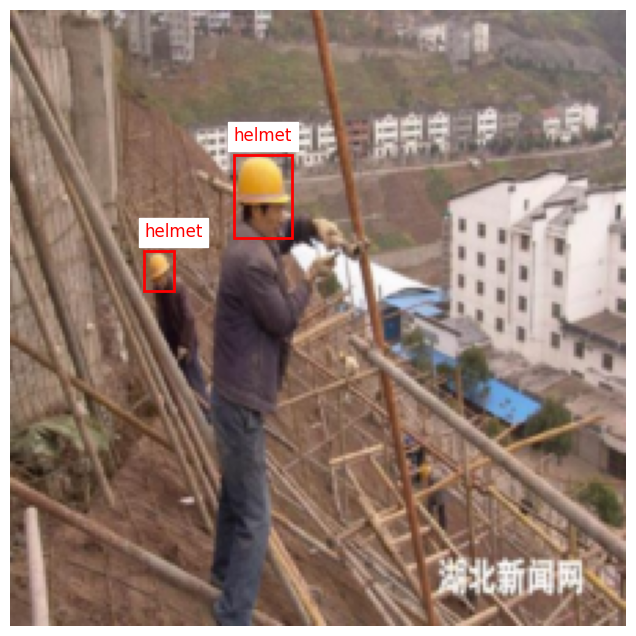

In [ ]:
# show the first image
train_dataset.show(0)

In [ ]:
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_batch_images(dataloader, class_names, batch_idx=0, image_size=4, title=None):
    """
    Display all images in a batch with their bounding boxes and labels.
    Args:
        dataloader (DataLoader): The PyTorch DataLoader containing the dataset.
        class_names (list): List of class names corresponding to class IDs.
        batch_idx (int): Index of the batch to display.
        image_size (int): Size of each image in the grid (controls the figure size).
        title (str): Title for the entire grid of images.
    """
    # Get the batch
    batch = next(iter(dataloader))
    images, labels = batch  # Assuming the dataloader yields (images, labels)

    # Number of images in the batch
    batch_size = len(images)
    grid_size = math.ceil(math.sqrt(batch_size))  # Calculate grid size for visualization

    # Dynamically calculate figure size based on grid size and image size
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(grid_size * image_size, grid_size * image_size))
    axs = axs.flatten()  # Flatten the axes array for easy iteration

    for i, (image, label_data) in enumerate(zip(images, labels)):
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()  # Convert Tensor to NumPy array

        # Get image dimensions
        img_height, img_width = image.shape[:2]

        # Plot image
        axs[i].imshow(image)
        axs[i].axis("off")

        # Parse and draw bounding boxes
        for line in label_data.strip().split("\n"):
            label_parts = line.split()
            class_id = int(label_parts[0])
            x_center, y_center, width, height = map(float, label_parts[1:])

            # Denormalize bounding box coordinates
            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height

            # Calculate top-left corner of the bounding box
            x_min = x_center - width / 2
            y_min = y_center - height / 2

            # Draw bounding box
            rect = patches.Rectangle(
                (x_min, y_min), width, height,
                linewidth=2, edgecolor='red', facecolor='none'
            )
            axs[i].add_patch(rect)

            # Add class label
            axs[i].text(
                x_min, y_min - 5,
                class_names[class_id],
                color='red', fontsize=8, backgroundcolor='white'
            )

    # Remove extra subplots if the batch size doesn't fill the grid
    for j in range(batch_size, len(axs)):
        axs[j].axis("off")

    # Add a title if provided
    if title:
        fig.suptitle(title + f"batch {batch_idx + 1}", fontsize=16, y=1.02)

    plt.tight_layout()
    plt.show()

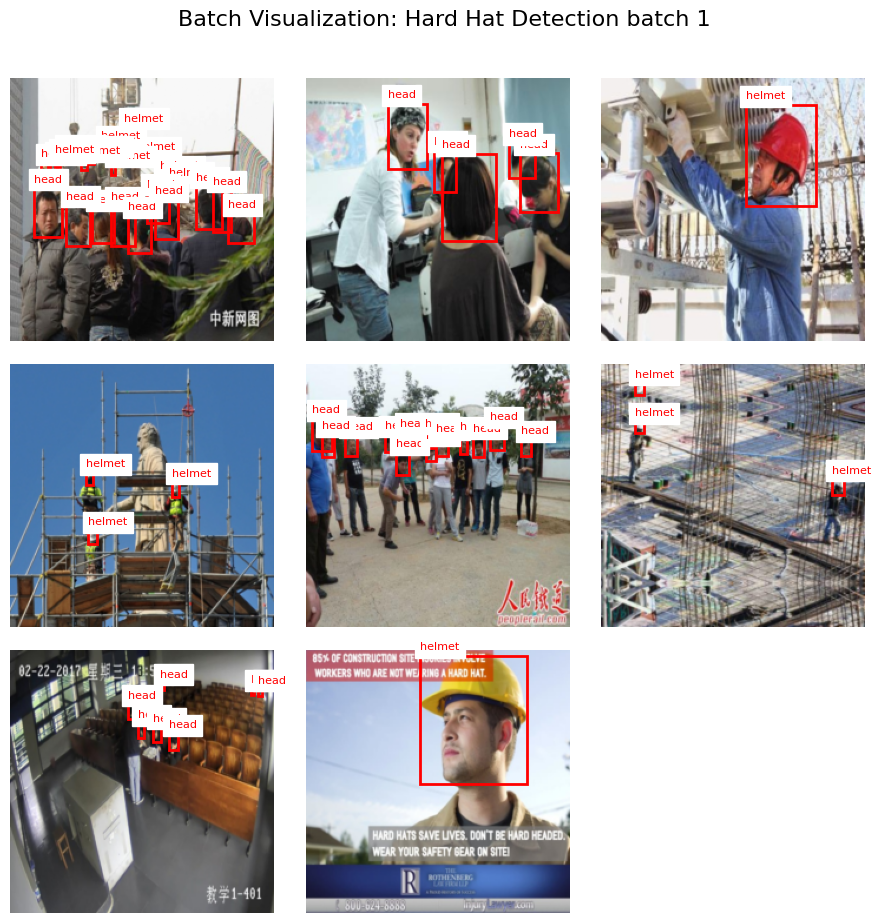

In [ ]:
show_batch_images(
    dataloader=train_loader,
    class_names=train_dataset.class_names,
    batch_idx=0,
    image_size=3,
    title="Batch Visualization: Hard Hat Detection "
)

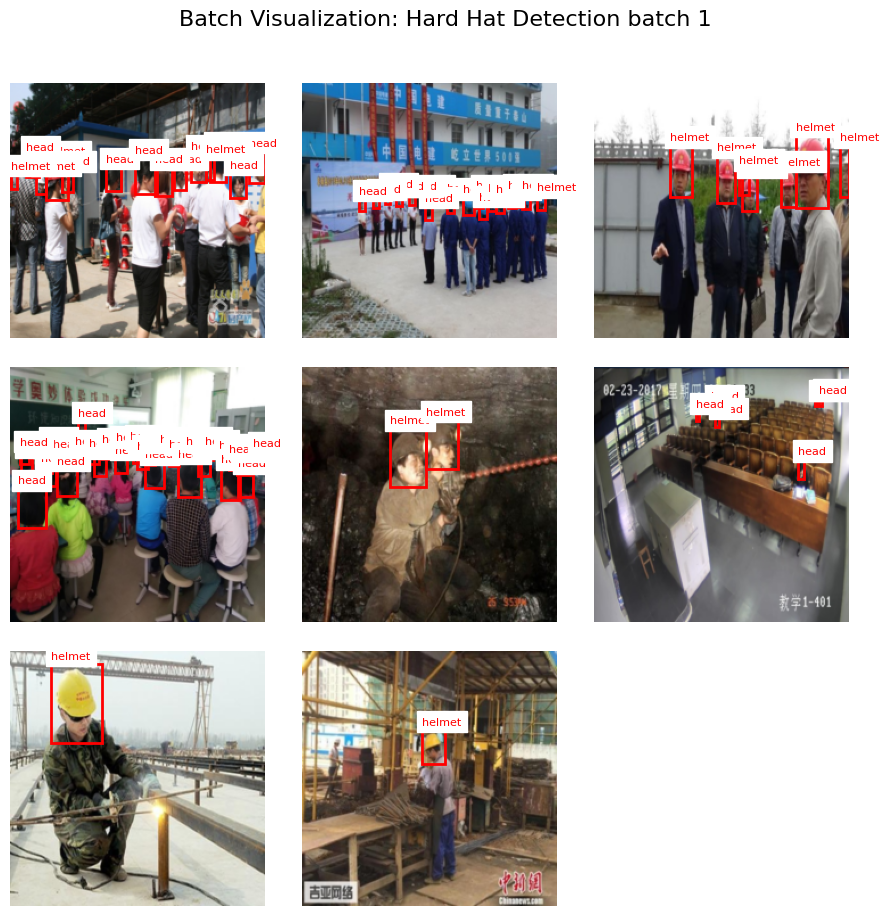

In [ ]:
show_batch_images(
    dataloader=train_loader,
    class_names=train_dataset.class_names,
    batch_idx=0,
    image_size=3,
    title="Batch Visualization: Hard Hat Detection "
)

##Model

In [ ]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 911.6/911.6 kB 29.2 MB/s eta 0:00:00


In [ ]:
!yolo train data=config.yaml model=yolov8n.pt epochs=100 imgsz=640 batch=16 device=0

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 6.25M/6.25M [00:00<00:00, 124MB/s]
Ultralytics 8.3.65 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=config.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=

##Testing

In [ ]:
!yolo predict model=/content/runs/detect/train/weights/best.pt data=config.yaml imgsz=640 source=datasets/images/test

Ultralytics 8.3.65 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs

image 1/2455 /content/datasets/images/test/000009.jpg: 640x640 2 helmets, 1 vest, 7.2ms
image 2/2455 /content/datasets/images/test/000010.jpg: 640x640 5 helmets, 5 vests, 7.3ms
image 3/2455 /content/datasets/images/test/000021.jpg: 640x640 1 helmet, 2 vests, 7.2ms
image 4/2455 /content/datasets/images/test/000022.jpg: 640x640 7 helmets, 7.2ms
image 5/2455 /content/datasets/images/test/000034.jpg: 640x640 1 helmet, 7.8ms
image 6/2455 /content/datasets/images/test/000036.jpg: 640x640 1 helmet, 7.2ms
image 7/2455 /content/datasets/images/test/000056.jpg: 640x640 7 heads, 7.2ms
image 8/2455 /content/datasets/images/test/000079.jpg: 640x640 1 helmet, 7.2ms
image 9/2455 /content/datasets/images/test/000097.jpg: 640x640 2 helmets, 7.2ms
image 10/2455 /content/datasets/images/test/000104.jpg: 640x640 4 helmets, 1 head, 7.2ms
image 1

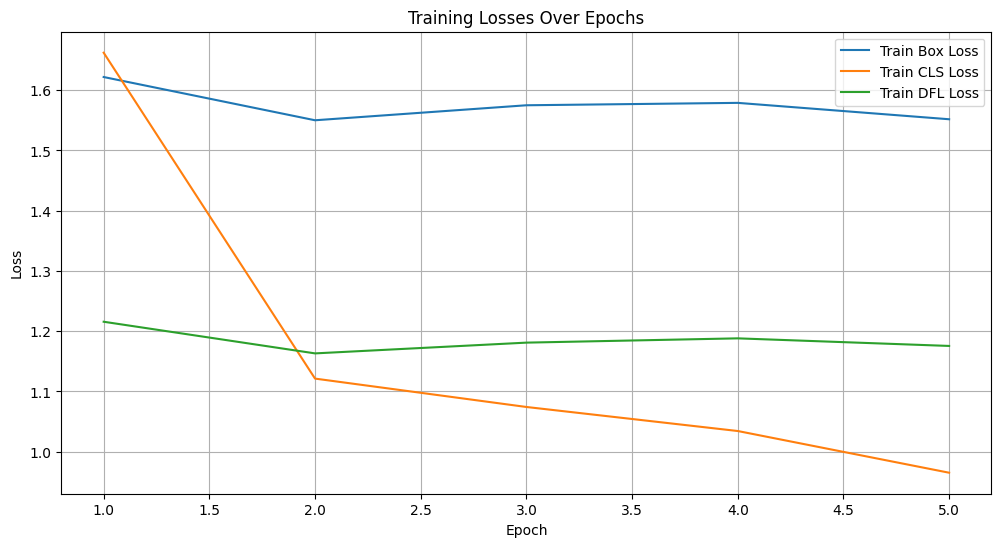

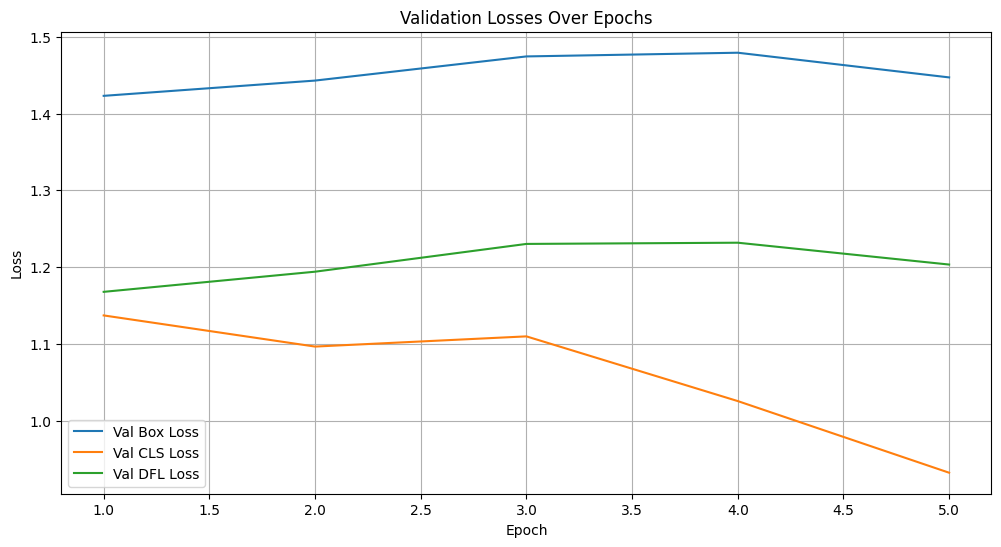

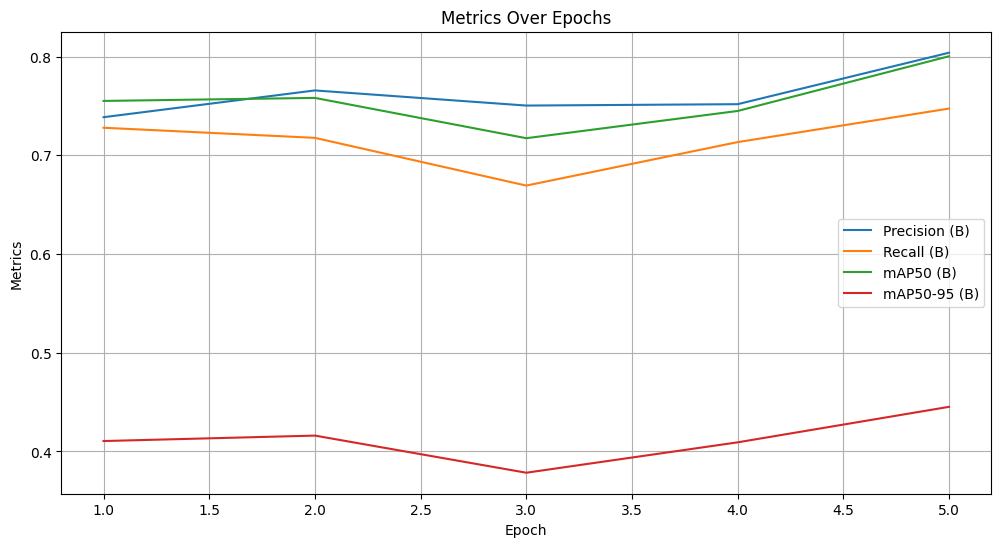

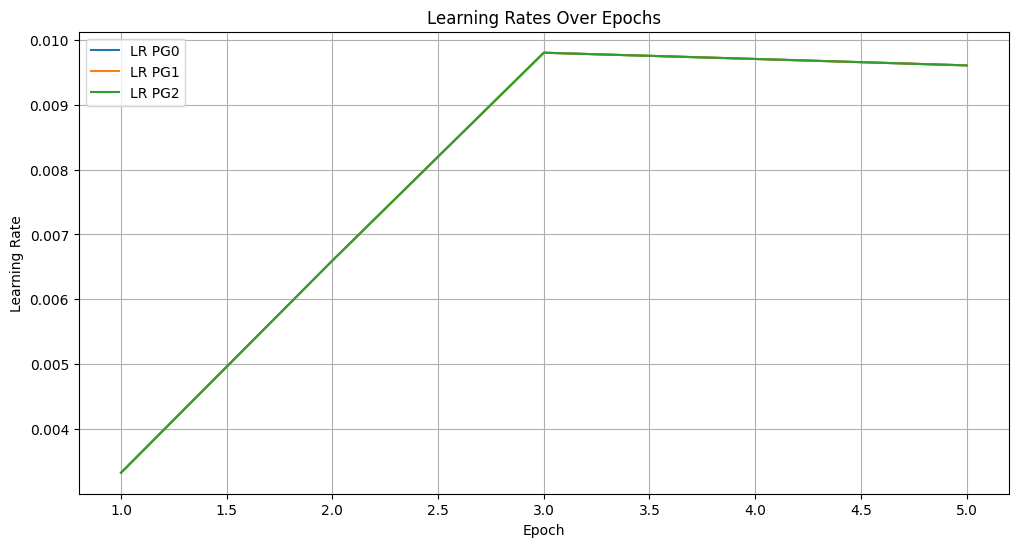

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from results.csv
df = pd.read_csv('/content/runs/detect/train/results.csv')

# Plot training losses
plt.figure(figsize=(12, 6))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss")
plt.plot(df["epoch"], df["train/cls_loss"], label="Train CLS Loss")
plt.plot(df["epoch"], df["train/dfl_loss"], label="Train DFL Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot validation losses
plt.figure(figsize=(12, 6))
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss")
plt.plot(df["epoch"], df["val/cls_loss"], label="Val CLS Loss")
plt.plot(df["epoch"], df["val/dfl_loss"], label="Val DFL Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Losses Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot precision, recall, and mAP metrics
plt.figure(figsize=(12, 6))
plt.plot(df["epoch"], df["metrics/precision(B)"], label="Precision (B)")
plt.plot(df["epoch"], df["metrics/recall(B)"], label="Recall (B)")
plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP50 (B)")
plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP50-95 (B)")
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.title("Metrics Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Plot learning rates
plt.figure(figsize=(12, 6))
plt.plot(df["epoch"], df["lr/pg0"], label="LR PG0")
plt.plot(df["epoch"], df["lr/pg1"], label="LR PG1")
plt.plot(df["epoch"], df["lr/pg2"], label="LR PG2")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rates Over Epochs")
plt.legend()
plt.grid()
plt.show()